## Initializations

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import PowerTransformer
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Test datasets
solTestX = pd.read_csv("solubility/solTestX.txt",delimiter="\t") #Test set
solTestXtrans = pd.read_csv("solubility/solTestXtrans.txt",delimiter="\t")#Test set predictors after the same transformations used on the training set are applied.
solTestY = pd.read_csv("solubility/solTestY.txt",delimiter="\t") #Test set - solubility values for each compound

# Train datasets
solTrainX = pd.read_csv("solubility/solTrainX.txt",delimiter="\t") #Train set
solTrainXtrans = pd.read_csv("solubility/solTrainXtrans.txt",delimiter="\t") #Training set predictors after transformations for skewness and centering/scaling.
solTrainY = pd.read_csv("solubility/solTrainY.txt",delimiter="\t") #Train set - solubility values for each compound

solTrainXtrans.index = range(1, len(solTrainXtrans) + 1) #Get dataset indexes starting from 1

In [26]:
continuous_predictors = ["MolWeight", "NumAtoms", "NumNonHAtoms", "NumBonds", "NumNonHBonds", "NumMultBonds", "NumRotBonds", "NumDblBonds", "NumAromaticBonds", "NumHydrogen", "NumCarbon", "NumNitrogen", "NumOxygen", "NumSulfer", "NumChlorine", "NumHalogen", "NumRings", "HydrophilicFactor", "SurfaceArea1", "SurfaceArea2", "x"]

## Data analysis and pre-procesing

In [27]:
XYTrain = solTrainXtrans.join(solTrainY)

In [52]:
#Complete dataset
dataset = pd.concat([solTrainXtrans[continuous_predictors[:-1]], solTestXtrans[continuous_predictors[:-1]]], axis=0)

In [59]:
#Dataset transformed with Yeo-jonhson
pt = PowerTransformer()
pt.fit(dataset)
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
totalXtrans = pd.DataFrame(pt.transform(dataset), columns=continuous_predictors[:-1])

In [73]:
#Given transformed dataset with box-cox
dataset_analysis = {
    'Min': dataset.min(),
    'Max': dataset.max(),
    'Mean': dataset.mean(),
    'Std': dataset.std(),
    'Skewness': dataset.skew()
}

df = pd.DataFrame(dataset_analysis)
df

,Min,Max,Mean,Std,Skewness
MolWeight,3.852061,6.502505,5.191686,0.473056,0.007898
NumAtoms,1.791759,4.553877,3.166294,0.455075,-0.076756
NumNonHAtoms,1.098612,3.871201,2.542373,0.451507,-0.061900
NumBonds,1.609438,4.584967,3.168753,0.486511,-0.200004
NumNonHBonds,0.743492,5.977009,3.351935,0.873186,0.029787
NumMultBonds,0.000000,6.979888,2.599741,1.715244,-0.106245
NumRotBonds,0.000000,2.833213,0.901067,0.715347,0.149147
NumDblBonds,0.000000,1.188042,0.388139,0.380337,0.195057
NumAromaticBonds,0.000000,3.332205,1.306359,1.124308,-0.180869
NumHydrogen,0.000000,7.314252,3.677272,1.180726,-0.036630


In [60]:
#Dataset transformed with Yeo-jonhson
dataset_analysis = {
    'Min': totalXtrans.min(),
    'Max': totalXtrans.max(),
    'Mean': totalXtrans.mean(),
    'Std': totalXtrans.std(),
    'Skewness': totalXtrans.skew()
}

df2 = pd.DataFrame(dataset_analysis)
df2

,Min,Max,Mean,Std,Skewness
MolWeight,-2.877281,2.735345,3.569888e-16,1.000395,-0.015032
NumAtoms,-2.912545,3.153292,-2.214137e-15,1.000395,0.010277
NumNonHAtoms,-3.116097,3.003131,-6.727934e-16,1.000395,-0.025140
NumBonds,-2.927674,3.144514,2.747955e-16,1.000395,0.018485
NumNonHBonds,-3.122068,2.918180,6.684121e-16,1.000395,-0.029812
NumMultBonds,-1.572948,2.361627,9.361099e-16,1.000395,-0.221484
NumRotBonds,-1.326407,2.287088,-6.207435e-16,1.000395,-0.089238
NumDblBonds,-1.050352,1.726593,-4.761604e-16,1.000395,0.030966
NumAromaticBonds,-1.172480,1.622886,2.432501e-16,1.000395,-0.234548
NumHydrogen,-3.004636,3.155104,-1.289857e-16,1.000395,0.039015


In [77]:
#Dataset transformed with Yeo-jonhson
pt = PowerTransformer()
pt.fit(solTrainX[continuous_predictors[:-1]])
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
Xtrain = pd.DataFrame(pt.transform(solTrainX[continuous_predictors[:-1]]), columns=continuous_predictors[:-1])
Xtrain = solTrainX.iloc[:, :207].join(Xtrain)

pt2 = PowerTransformer()
pt2.fit(solTestX[continuous_predictors[:-1]])
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
Xtest = pd.DataFrame(pt.transform(solTestX[continuous_predictors[:-1]]), columns=continuous_predictors[:-1])
Xtest = solTestX.iloc[:, :207].join(Xtest)

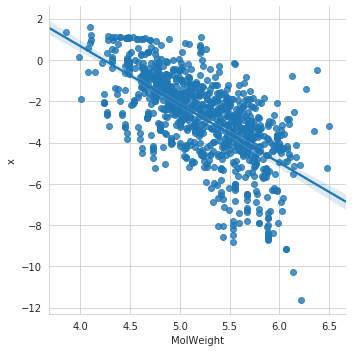

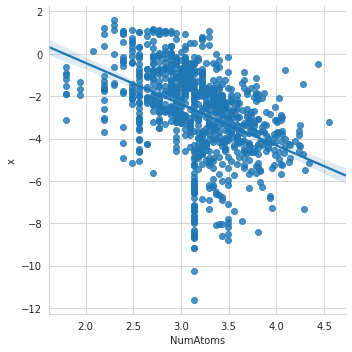

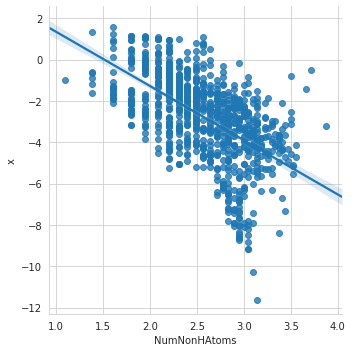

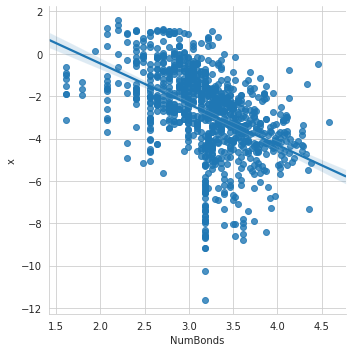

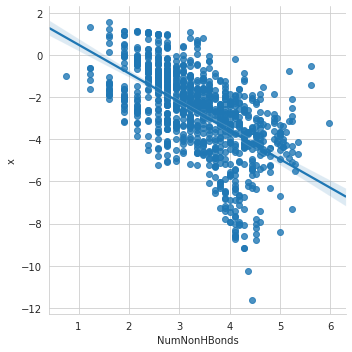

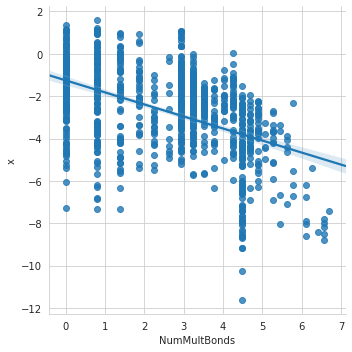

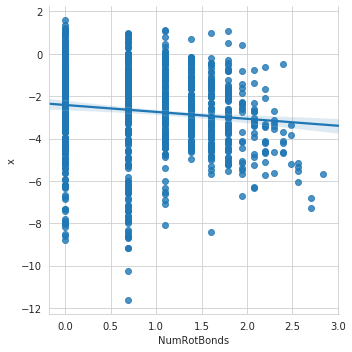

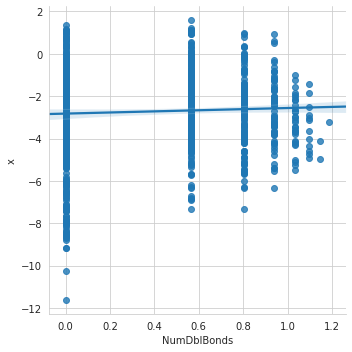

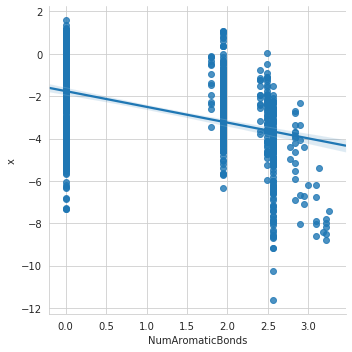

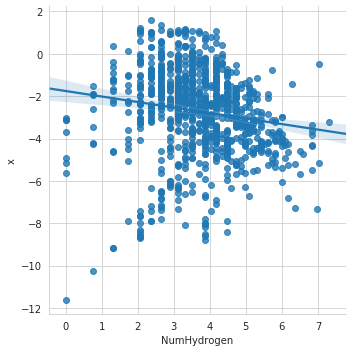

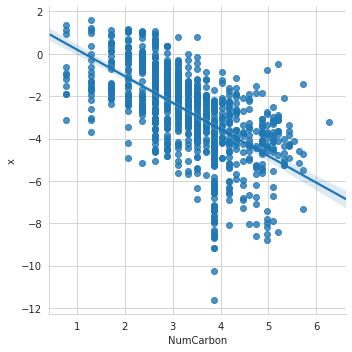

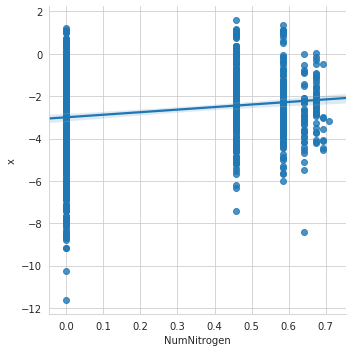

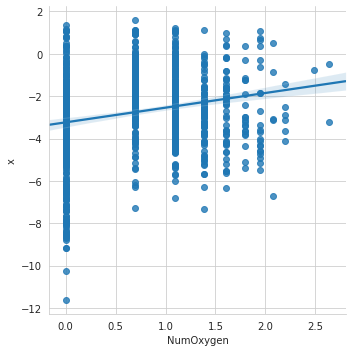

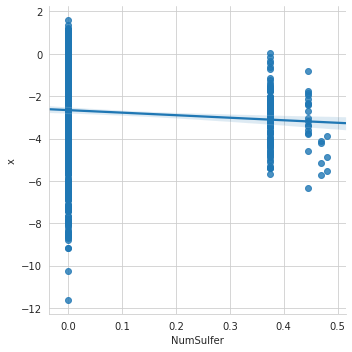

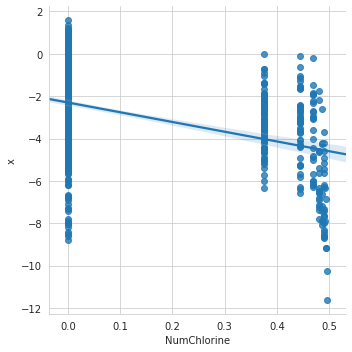

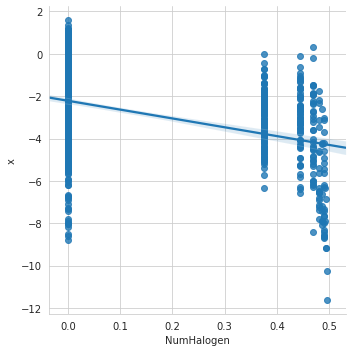

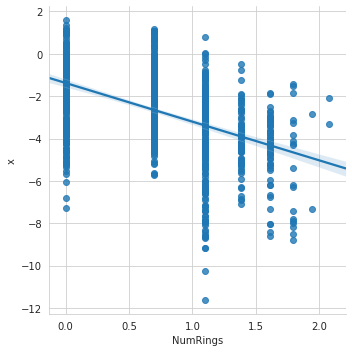

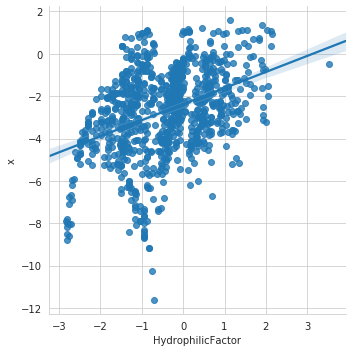

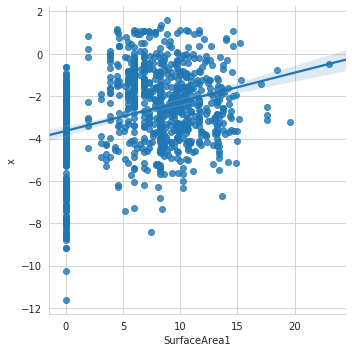

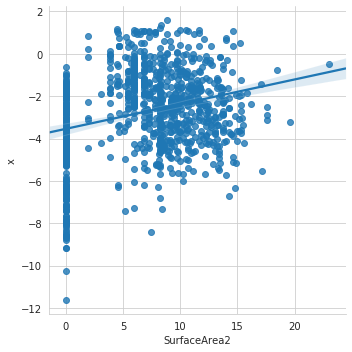

In [30]:
for x in continuous_predictors[:-1]:
    sns.lmplot(x=x, y="x", data=XYTrain)    
plt.show()

In [31]:
solTrainXcontinous = solTrainXtrans.iloc[:,208:]

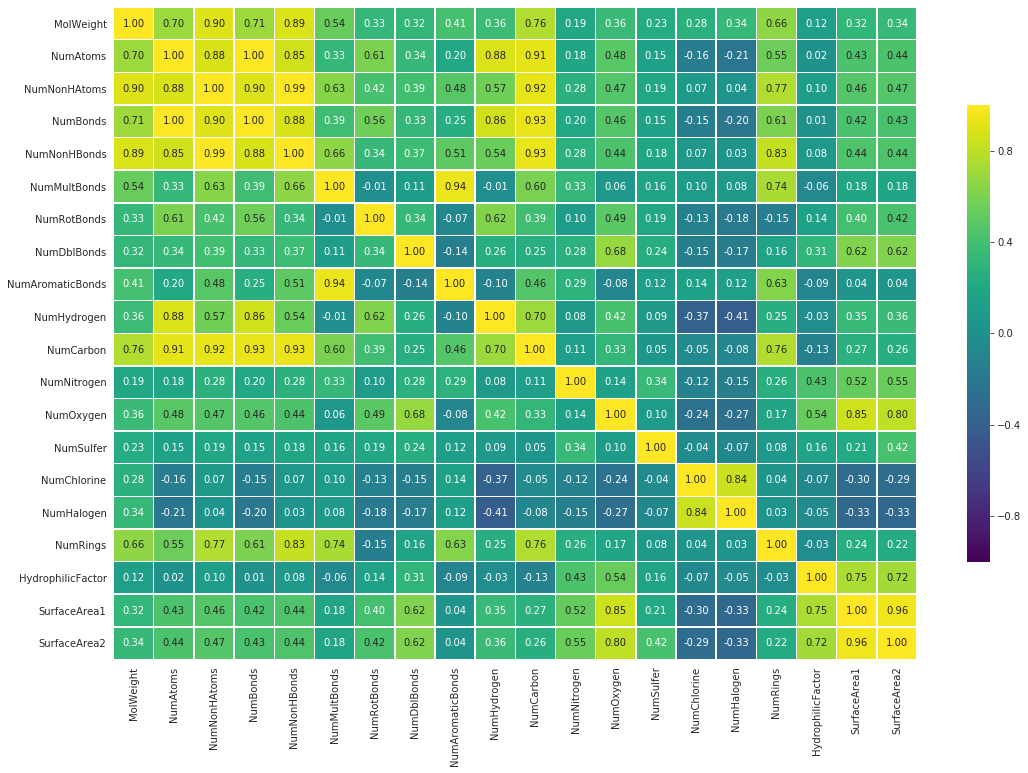

In [32]:
corr = XYTrain[continuous_predictors[:-1]].corr()
mask = np.zeros_like(corr)

f, ax = plt.subplots(figsize=(18, 12))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    ax=ax, 
    vmin=-1, vmax=1, 
    cmap="viridis",
    cbar_kws={"shrink": .7}
)

## Oridnary linear regression

In [33]:
lm = LinearRegression()
model = lm.fit(solTrainXtrans, solTrainY)
Ypred = model.predict(solTestXtrans)

print('RMSE', np.sqrt(mean_squared_error(solTestY, Ypred)))
print('R2', r2_score(solTestY, Ypred))

RMSE 0.7455801896508937
R2 0.8709146842068279


## Cross-validation

In [34]:
lr = LinearRegression()
MSEs = cross_val_score(lm, solTrainXtrans, solTrainY, scoring='neg_mean_squared_error', cv=10)
mean_MSE = np.mean(np.abs(MSEs))
print(np.sqrt(mean_MSE))

0.7563265449594029


In [35]:
kf = KFold(n_splits=10, random_state=100, shuffle=True)

R2 = []
RMSE = []

for train_index, test_index in kf.split(solTrainXtrans):
    x_train = solTrainXtrans.iloc[train_index]
    y_train = solTrainY.iloc[train_index]
    
    x_test = solTrainXtrans.iloc[test_index]
    y_test = solTrainY.iloc[test_index]
    
    lm = LinearRegression()
    lm.fit(x_train, y_train)
    
    preds = lm.predict(x_test)
    
    RMSE.append(np.sqrt(mean_squared_error(y_test, preds)))
    R2.append(r2_score(y_test, preds))

print('RMSE', np.mean(RMSE))
print('R2', np.mean(R2))

RMSE 0.7194162446075096
R2 0.8674703401067628


# OLR Plots

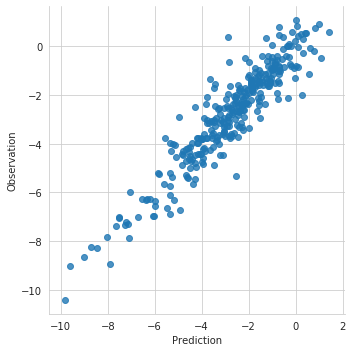

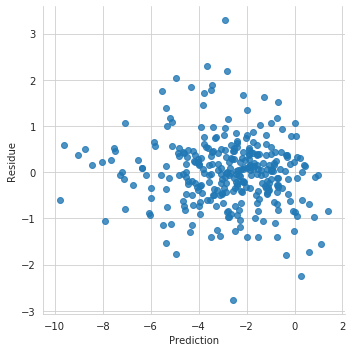

In [36]:
Ypred_ = sum(Ypred.tolist(), [])
solTestY_ = sum(solTestY.values.tolist(), [])
resid = [y_test - y_pred for y_test, y_pred in zip(solTestY_, Ypred_)]

df1 = pd.DataFrame({'Prediction':Ypred_, 'Observation':solTestY_})
sns.lmplot(x='Prediction', y="Observation", data=df1, fit_reg=False)

df2 = pd.DataFrame({'Prediction': Ypred_, 'Residue': resid})
sns.lmplot(x='Prediction', y="Residue", data=df2, fit_reg=False)


## Removing high correlated predictors

In [37]:
corr_matrix = solTrainX.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

newX = solTrainX.drop(to_drop, axis=1)
newXtest = solTestX.drop(to_drop, axis=1)

model2 = LinearRegression().fit(newX, solTrainY)
Ypred2 = model2.predict(newXtest)

print('RMSE', np.sqrt(mean_squared_error(solTestY, Ypred2)))
print('R2', r2_score(solTestY, Ypred2))

RMSE 0.7935394417667746
R2 0.8537738126363427


# Penalized linear regression model L2 (Ridge)

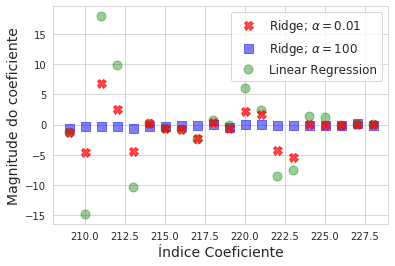

In [38]:
lr = LinearRegression()
lr.fit(solTrainXtrans, solTrainY)

rr = Ridge(alpha=0.03)
rr.fit(solTrainXtrans, solTrainY)

rr3 = Ridge(alpha=100)
rr3.fit(solTrainXtrans, solTrainY)

plt.plot(range(209, 229), rr.coef_[0][208:],alpha=0.7,linestyle='none',marker='X',markersize=9,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(range(209, 229), rr3.coef_[0][208:],alpha=0.5,linestyle='none',marker='s',markersize=9,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(range(209, 229), lr.coef_[0][208:],alpha=0.4,linestyle='none',marker='o',markersize=9,color='green',label='Linear Regression')

plt.xlabel('Índice Coeficiente',fontsize=14)
plt.ylabel('Magnitude do coeficiente',fontsize=14)
plt.legend(fontsize=12,loc=1)
plt.show()

In [39]:
ridge = Ridge()
params = {'alpha': np.linspace(0.1, 15,100)}
ridge_regressor = GridSearchCV(ridge, params, scoring=('r2', 'neg_mean_squared_error'), cv=10, refit='neg_mean_squared_error')
ridge_regressor.fit(solTrainXtrans, solTrainY)

print(ridge_regressor.best_params_)
print(np.sqrt(np.abs(ridge_regressor.best_score_)))

{'alpha': 8.377777777777776}
0.7025359331258679


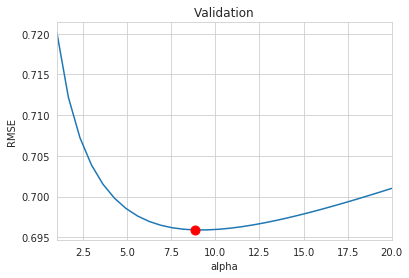

8.862068965517242


In [40]:
alphas = np.linspace(1,20,30)
cv_ridge = [np.sqrt(-cross_val_score(Ridge(alpha = alpha), solTrainXtrans, solTrainY, scoring="neg_mean_squared_error", cv = 10)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")

alpha_min = alphas[cv_ridge.tolist().index(cv_ridge.min())]

plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.plot(alpha_min, cv_ridge.min(), marker='o', markersize=9, color='red')
plt.show()
print(alpha_min)

In [41]:
alphas = np.linspace(0.01, 0.1, 15)
R2 = []
RMSE = []

for alpha in alphas:
    rr = RidgeCV(alphas=[alpha], cv=10) 
    rmodel = rr.fit(solTrainXtrans, solTrainY)
    Ypred = rmodel.predict(solTestXtrans)
    
    R2.append(r2_score(solTestY, Ypred))
    RMSE.append(np.sqrt(mean_squared_error(solTestY, Ypred)))

df = pd.DataFrame(
    {
        'alpha': alphas,
        'RMSE': RMSE,
        'R2': R2
    }
)
df

,alpha,RMSE,R2
0,0.010000,0.744797,0.871186
1,0.016429,0.745190,0.871050
2,0.022857,0.745618,0.870902
3,0.029286,0.745998,0.870770
4,0.035714,0.746314,0.870660
5,0.042143,0.746569,0.870572
6,0.048571,0.746768,0.870503
7,0.055000,0.746921,0.870450
8,0.061429,0.747033,0.870411
9,0.067857,0.747111,0.870384


## Parcial Least Squares regression (PLS)

19 0.7361631410892916


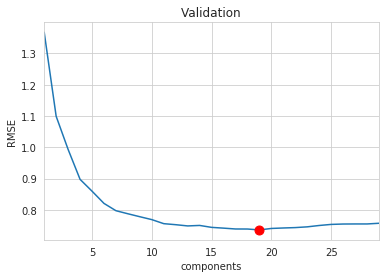

In [42]:
components = range(1,30)

cv_pls = [np.sqrt(-cross_val_score(PLSRegression(n_components=comps), solTrainXtrans, solTrainY, scoring='neg_mean_squared_error', cv=10)).mean() for comps in components]
cv_pls = pd.Series(cv_pls, index = components)

cv_pls.plot(title='Validation')

n_comp_min = components[cv_pls.tolist().index(cv_pls.min())]

print(n_comp_min, cv_pls.min())

plt.xlabel("components")
plt.ylabel("RMSE")
plt.plot(n_comp_min, cv_pls.min(), marker='o', markersize=9, color='red')
plt.show()

In [76]:
pls = PLSRegression(n_components = 19)

pls.fit(solTrainXtrans, solTrainY)
Ypred_pls = pls.predict(solTestXtrans)
Ytest_pls = solTestY

score = r2_score(Ytest_pls, Ypred_pls)
rmse = np.sqrt(mean_squared_error(Ytest_pls, Ypred_pls))

print('R2', score)
print('RMSE', rmse)

R2 0.8756252345390565
RMSE 0.7318499992933136


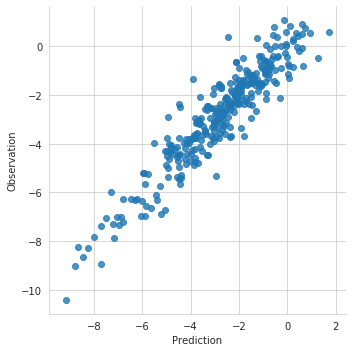

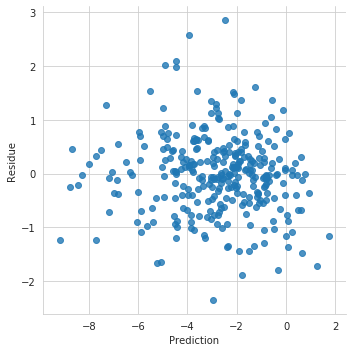

In [44]:
Ypred_ = sum(Ypred_pls.tolist(), [])
Ytest_ = sum(Ytest_pls.values.tolist(), [])
resid = [y_test - ypred for y_test, ypred in zip(Ytest_, Ypred_)]

df1 = pd.DataFrame({'Prediction': Ypred_, 'Observation': Ytest_})
sns.lmplot(x='Prediction', y="Observation", data=df1, fit_reg=False)

df2 = pd.DataFrame({'Prediction': Ypred_, 'Residue': resid})
sns.lmplot(x='Prediction', y="Residue", data=df2, fit_reg=False)

plt.show()